In [1]:
import pickle
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from VenusOpt.utils import loadXy, RBF_BEST_PARAMS, gpr_to_venus, get_scaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import preprocessing
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn_evaluation import plot
from plot4d import plotter


RANDSTATE = 42

In [19]:
old_data = False

results_matern = {}
lc_range = np.linspace(0.2, 10, 10)
nu_range = [0.5, 1.5, 2.5, float('inf')]

for run_idx in ['1']: # , '2', '3'
  datafile = "../Data/data%s.pkl"%run_idx if old_data else "../New Data/accumulated_weekend_data.h5"
  X, y, X_var = loadXy(datafile, old=old_data, run_idx=run_idx, use_datanorm=True)
  # hyper parameters
  param_grid = {
    'kernel__length_scale':list(lc_range),
    'kernel__nu':nu_range
  }

  kernel = Matern()

  gpr = GaussianProcessRegressor(
      kernel=kernel, alpha=X_var.mean(), optimizer=None
  )

  X, y = sklearn.utils.shuffle(X,y)

  clf = GridSearchCV(estimator=gpr, param_grid=param_grid).fit(X, y)
  results_matern[run_idx] = clf
  
results_matern['1'].cv_results_["mean_test_score"].mean()

[127.52331026  97.61776     94.87581308 ... 133.31091538 133.50248718
 134.05288205]


0.7060796252211116

In [20]:
results_matern['1'].best_params_

{'kernel__length_scale': 2.377777777777778, 'kernel__nu': 0.5}

In [21]:
run_idx = '1'
venus = gpr_to_venus(results_matern[run_idx], get_scaler(use_datanorm=True))
plotter.plot4d(venus.bbf, np.linspace(116, 128, 30), wbounds=(0, 170), 
               bound2d=plotter.Bound2d(97, 110, 97, 110), 
               func_name="MATERN_best_fit_exp%s_old%r"%(run_idx, old_data), 
               fps=5, save_images=False)

'MATERN_best_fit_exp1_oldFalse.gif'

In [18]:
venus.bbf(100,100,120)

1.0080657855552886

### RBF Kernel Fit (Not updated to the latest version of loadXy)

In [2]:
results = {}
lc_range = np.linspace(1e-3, 2, 100)

for run_idx in ['1', '2', '3']:
  X, y, X_var = loadXy("../New Data/accumulated_weekend_data.h5", run_idx=run_idx, use_datanorm=True)
  # hyper parameters
  param_grid = [
    {'kernel__length_scale':list(lc_range)},
  ]

  kernel_RBF = RBF(length_scale_bounds="fixed") #length_scale_bounds="fixed"
  #TODO: check if we want sklearn to autofit some of these paramters

  gpr = GaussianProcessRegressor(
      kernel=kernel_RBF, alpha=X_var.mean(), optimizer=None
  )

  X, y = sklearn.utils.shuffle(X,y)

  clf = GridSearchCV(estimator=gpr, param_grid=param_grid).fit(X, y)
  results[run_idx] = clf.cv_results_['mean_test_score']
  

KeyboardInterrupt: 

In [15]:
# results

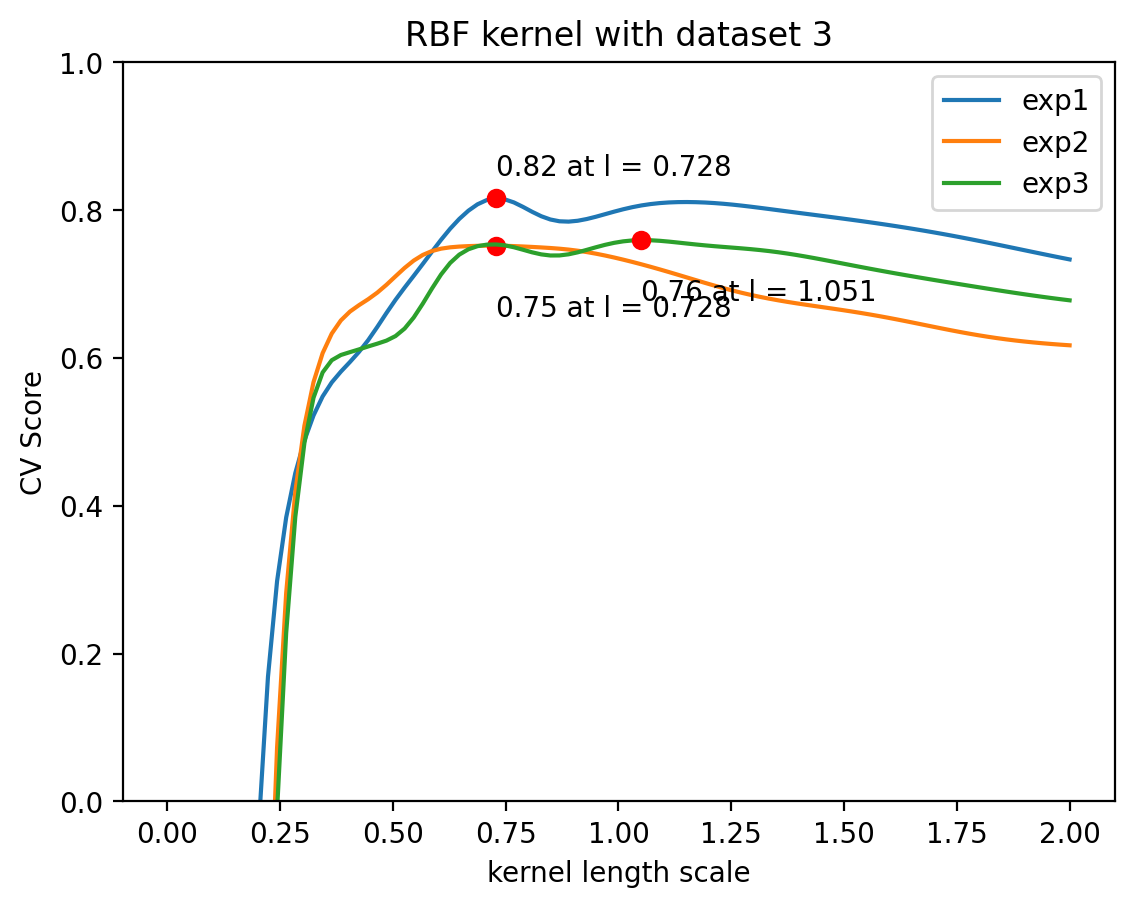

In [16]:
for run_idx, resultsi in results.items():
    best_arg = np.argmax(resultsi)
    best_param = lc_range[best_arg]
    best_score = resultsi[best_arg]
    plt.plot(lc_range, resultsi, label="exp%s"%run_idx)
    plt.plot(best_param, best_score,'ro')
    plt.text(best_param, 3*best_score-1.6,'%.2f at l = %.3f'%(best_score, best_param))
plt.title("RBF kernel with dataset %s"%run_idx)
plt.xlabel("kernel length scale")
plt.ylabel("CV Score")
plt.ylim(0,1)
plt.legend()
plt.savefig("../Graphs/RBF_ls_datanorm.png")
plt.show()

### Using the best RBF parameters found

In [30]:
run_idx = '2'
X, y, X_var = loadXy("../New Data/accumulated_weekend_data.h5", run_idx=run_idx, use_datanorm=True)
X, y = sklearn.utils.shuffle(X,y)

gpr = GaussianProcessRegressor(
    kernel=RBF(length_scale_bounds="fixed") , alpha=X_var.mean(), optimizer=None
)

gpr.set_params(**RBF_BEST_PARAMS[run_idx])
gpr.fit(X, y)

GaussianProcessRegressor(alpha=0.0031657683008575596,
                         kernel=RBF(length_scale=0.173), optimizer=None)

In [31]:

venus = gpr_to_venus(gpr, get_scaler())
plotter.plot4d(venus.bbf, np.linspace(116, 128, 30), wbounds=(0, 170), 
               bound2d=plotter.Bound2d(97, 110, 97, 110), 
               func_name="RBF_best_fit_exp%s_datanorm"%run_idx, fps=5, save_images=False)

'RBF_best_fit_exp2_datanorm.gif'

In [25]:
venus.bbf(98, 98, 120)

5.901838614411194

The resulting gif is not what we like to see. Over simplified. 

In [13]:
# hyper parameters
param_grid = [
  {'kernel__length_scale':[0.8, 1.0], 'kernel__nu':[0.66, 0.86]},
]

kernel = Matern(length_scale_bounds="fixed") 
kernel_RBF = RBF(length_scale_bounds="fixed")
#TODO: check if we want sklearn to autofit some of these paramters

gpr = GaussianProcessRegressor(
    kernel=kernel, alpha=X_var.mean(), n_restarts_optimizer=9
) 

clf = GridSearchCV(estimator=gpr, param_grid=param_grid)
clf.fit(X, y)
with open("../Results/gs_clf.dump" , "wb") as f:
    pickle.dump(clf, f)


In [3]:
out

array([0.86230296, 0.76214242, 0.68104857, 0.83227535, 0.78560923])

### Matern Kernel Fit

In [66]:
old_data = True
datanorm = True

results = {}
lc_range = np.linspace(0.2, 20, 100)
# nu_range = list(np.linspace(0.3, 0.8, 5))
nu_range = [0.5, 1.5, 2.5, float('inf')]

for run_idx in ['1', '2', '3']: # 
  datafile = "../Data/data%s.pkl"%run_idx if old_data else "../New Data/accumulated_weekend_data.h5"
  X, y, X_var = loadXy(datafile, old=old_data, run_idx=run_idx, use_datanorm=datanorm)
  # hyper parameters
  param_grid = {
    'kernel__length_scale':list(lc_range),
    'kernel__nu':nu_range
  }

  kernel = Matern()

  gpr = GaussianProcessRegressor(
      kernel=kernel, alpha=X_var.mean(), optimizer=None
  )

  X, y = sklearn.utils.shuffle(X,y)

  clf = GridSearchCV(estimator=gpr, param_grid=param_grid).fit(X, y)
  results[run_idx] = clf
  

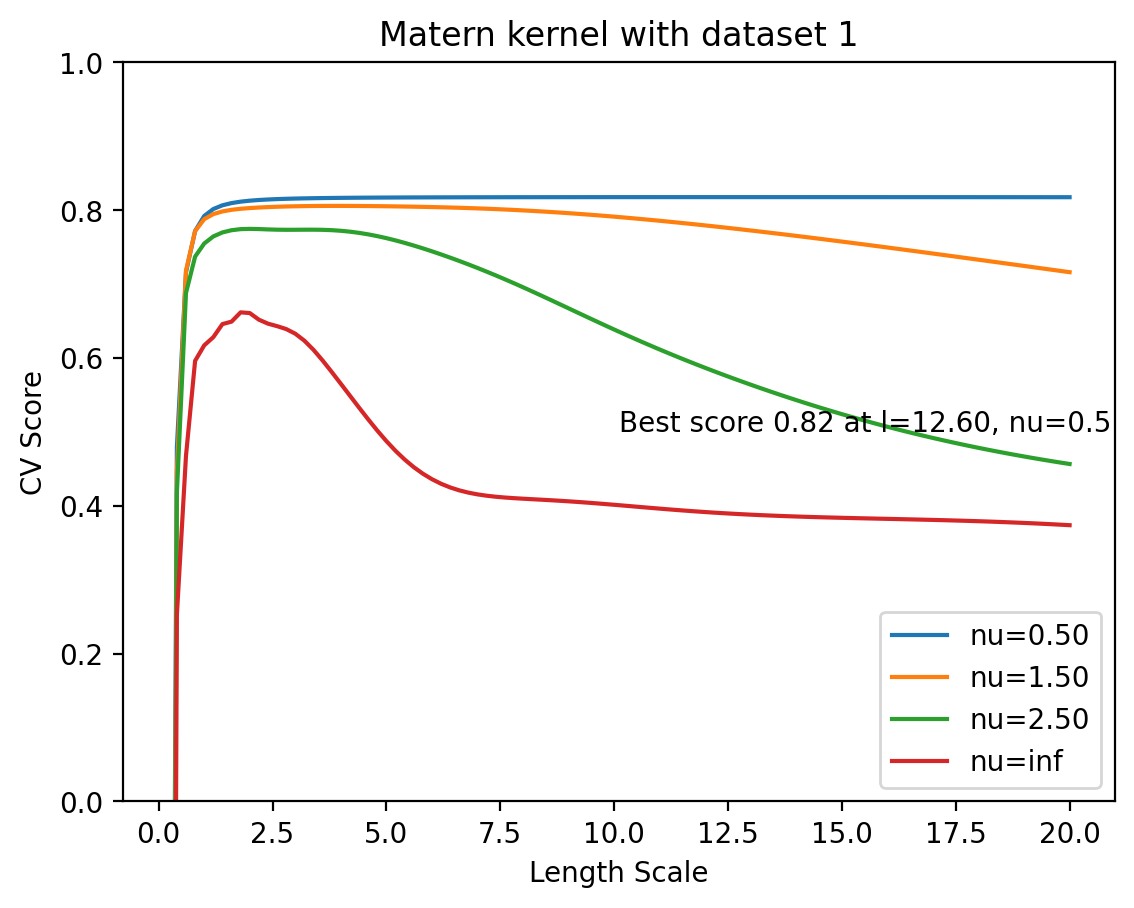

In [70]:
run_idx = '1'
result = results[run_idx].cv_results_['mean_test_score'].reshape(len(lc_range), len(nu_range))

for i, nu in enumerate(nu_range):
    plt.plot(lc_range,result[:, i], label="nu=%.2f"%nu) # , marker='x'
    plt.ylim(0,1)
best_lengh_scale = results[run_idx].best_params_["kernel__length_scale"]
text = "Best score %.2f at l=%.2f, nu=%s"%(results[run_idx].best_score_, 
                                           results[run_idx].best_params_["kernel__length_scale"],
                                           results[run_idx].best_params_["kernel__nu"])
plt.text((lc_range[0]+lc_range[-1])/2, 0.5, text)
plt.title("Matern kernel with dataset %s"%run_idx)
plt.xlabel("Length Scale")
plt.ylabel("CV Score")
plt.legend()
plt.savefig("../Graphs/Matern_tuning_exp%s_l0.2to20_datanorm_old%r.png"%(run_idx, old_data))
plt.show()

In [73]:
from VenusOpt.utils import get_scaler
run_idx = '1'
venus = gpr_to_venus(results[run_idx], get_scaler(use_datanorm=datanorm))
plotter.plot4d(venus.bbf, np.linspace(116, 128, 30), bound2d=plotter.Bound2d(97, 110, 97, 110), 
               wbounds=(0, 170),
               func_name="Matern_best_fit_exp%s_datanorm_old%r"%(run_idx, old_data), fps=5, save_images=False)

'Matern_best_fit_exp1_datanorm_oldTrue.gif'

In [38]:
venus.bbf(97,97,120)

82.76247454231543

## Graveyard

In [37]:
run_num = "3"
with open("../Results/gs_clf_run%s_nu10.000000to60.000000_l0.100000to10.000000.dump"%run_num , "rb") as f:
        clf_loaded = pickle.load(f)

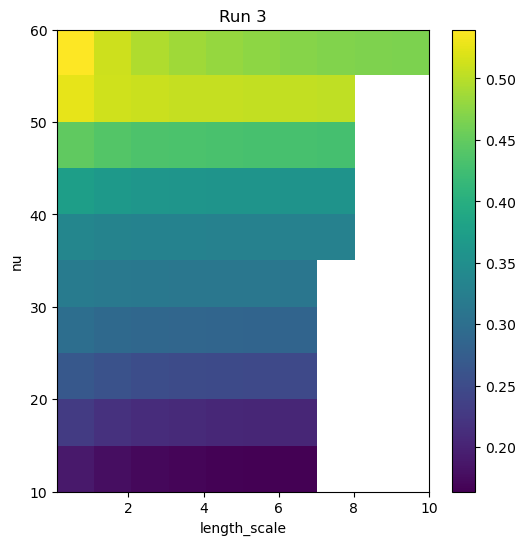

{'kernel__length_scale': 1.2000000000000002, 'kernel__nu': 54.44444444444444}


In [38]:
clf_loaded.cv_results_

results = clf_loaded.cv_results_['mean_test_score'].reshape((10, 10))

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(results, extent=(0.1,10,10,60))
ax.set_aspect("auto")
plt.xlabel("length_scale")
plt.ylabel("nu")
plt.title("Run %s"%run_num)
plt.colorbar(im)
plt.savefig("../Graphs/gs_run%s.png"%run_num)
plt.show()
print(clf_loaded.cv_results_['params'][results.argmax()])

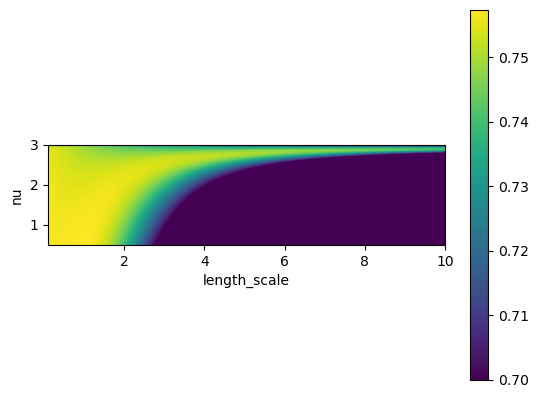

{'kernel__length_scale': 10.0, 'kernel__nu': 0.702020202020202}


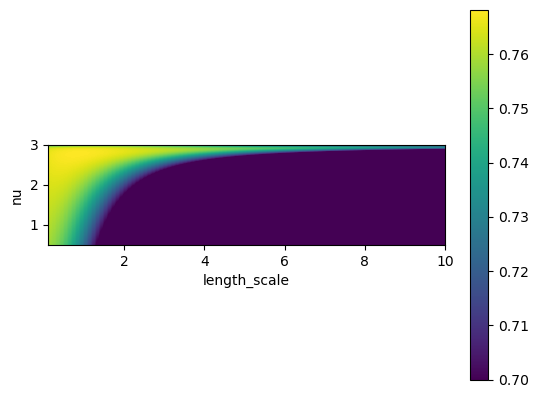

{'kernel__length_scale': 1.0, 'kernel__nu': 0.6767676767676768}


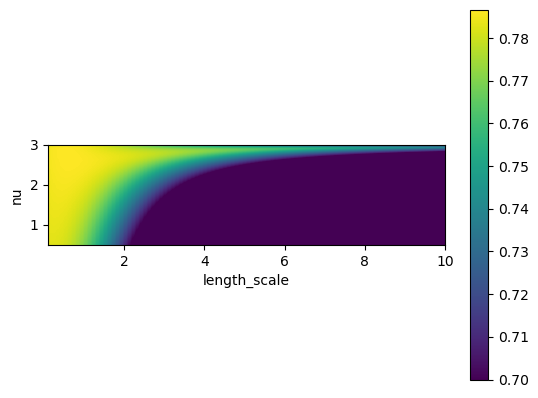

{'kernel__length_scale': 1.4000000000000001, 'kernel__nu': 0.6262626262626263}


In [4]:
for i in ['1','2','3']:
    with open("../Results/gs_clf_trial%s.dump"%i , "rb") as f:
        clf_loaded = pickle.load(f)
    results = clf_loaded.cv_results_['mean_test_score'].reshape((100, 100))
    im = plt.imshow(results, extent=(0.1,10,0.5,3), vmin=0.7)
    plt.xlabel("length_scale")
    plt.ylabel("nu")
    plt.colorbar(im)
    plt.show()
    print(clf_loaded.cv_results_['params'][results.argmax()])

In [48]:
results.max()

0.7865858052405486

In [49]:
results.argmax()

1305

In [50]:
clf_loaded.cv_results_['params'][results.argmax()]

{'kernel__length_scale': 1.4000000000000001, 'kernel__nu': 0.6262626262626263}